In [2]:
%matplotlib inline
import pysal as ps
import numpy as np
import pandas as pd
import geopandas as gp
import shapely
import copy
import random
import acs_regionalization as ACS
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20,20  #set the default map size
#rcParams['patch.linewidth'] = 0.5  #set default polygon line width

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # print all output, not just last

(-93.24031534999999, -92.97199565, 44.87554229999999, 45.1363897)

[]

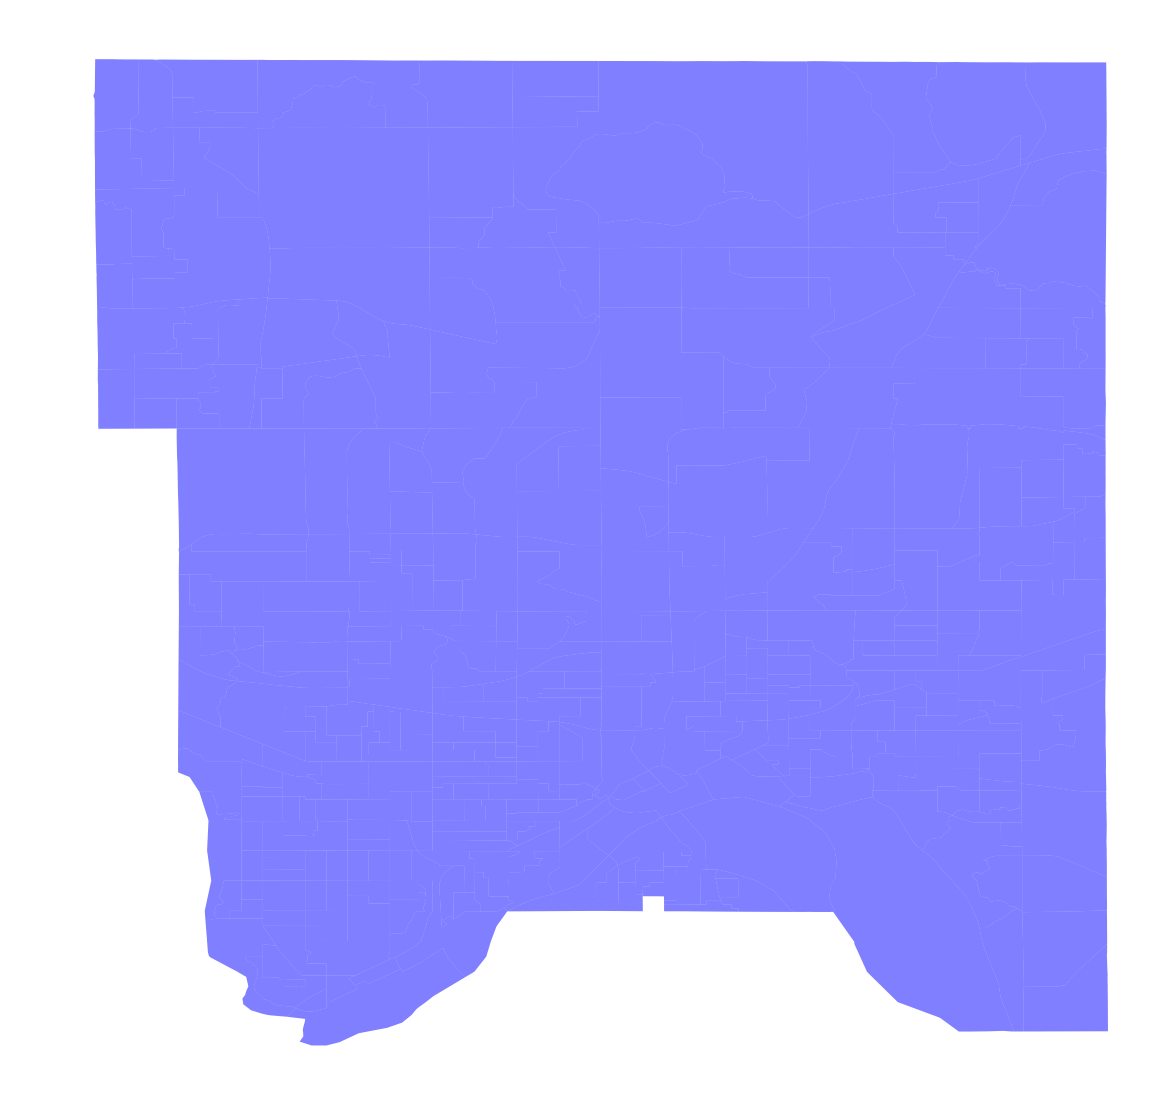

In [3]:
# read in the Ramsey shapefile and plot it   
shp_map = gp.read_file('example_data/ramsey.shp')
shp_map['constant'] = 1
p = shp_map.plot('constant', alpha=0.5, cmap='winter')
p.axis('off')
p.plot()

In [5]:
# read spatial data into python and run some diagnostics
w = ps.rook_from_shapefile('example_data/ramsey.shp', idVariable='GEOID')
print w.n   # number of block groups

401


<BarContainer object of 11 artists>

Text(0.5,0,'number of neighbors')

Text(0,0.5,'number of block groups')

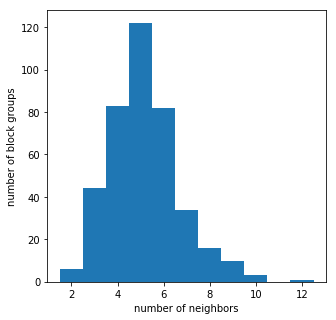

In [6]:
# summary of the connectivity structure of the Ramsey block groups
w_hist_data = np.array(w.histogram)
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(w_hist_data[:,0], w_hist_data[:,1], align='center', width=1)
ax.set_xlabel('number of neighbors')
ax.set_ylabel('number of block groups')
# shows, for example, that ~120 tracts have 5 neighbors

In [8]:
# read in list of census tracts to exclude
exclude = open('example_data/all_exclude_ramsey.csv')
exclude = exclude.readline()
exclude = exclude.replace('g','')
exclude = exclude.split(',')
print exclude

['271239800001']


In [18]:
# read in the ACS estimates and standard errors
population = pd.read_csv('example_data/all_count_est_ramsey.csv', index_col=0)

population.shape
population.head

poverty_est_prop = pd.read_csv('example_data/poverty_prop_est_ramsey.csv', index_col=0)
poverty_moe_prop = pd.read_csv('example_data/poverty_moe_est_ramsey.csv', index_col=0)

white_est_prop = pd.read_csv('example_data/white_prop_est_ramsey.csv', index_col=0)
white_moe_prop = pd.read_csv('example_data/race_moe_est_ramsey.csv', index_col=0) 

(401, 1)

<bound method DataFrame.head of               ACS11_5yr_B01003001
id                               
271230301001                  858
271230301002                 1381
271230301003                  842
271230301004                  820
271230301005                 1132
271230302011                 1218
271230302012                 1559
271230302013                 1113
271230302014                 1545
271230302021                 2205
271230303001                 1016
271230303002                  957
271230303003                  819
271230303004                  742
271230303005                  614
271230303006                  799
271230303007                 1152
271230304001                 2159
271230304002                 2913
271230304003                 2048
271230305001                 2263
271230305002                 1983
271230305003                  703
271230305004                  995
271230306011                 3397
271230306012                 2848
271230306021    

In [29]:
shp = ps.open('example_data/ramsey.shp')
random.seed(789)     # to ensure we get the same solution each time
np.random.seed(789)  # to ensure we get the same solution each time
results = ACS.ACS_Regions(w=w,\
                          target_est_prop=white_est_prop.values,\
                          target_moe_prop=white_moe_prop.values,\
                          count_est=population.values,\
                          target_th_all=0.10,\
                          exclude=exclude,\
                          compactness=shp,\
                          cv_exclude_prop=0.05)
print 'regionalization finished'

regionalization finished


In [30]:
# some basic diagnostics on the solution
print 'number of regions:', len(results.regions)
print 'total time (seconds):', results.time['total']

number of regions: 229
total time (seconds): 45.5279998779


In [27]:
# We'll make a few side-by-side plots. This code wraps the setup into a function.
def two_plot_setup():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40,40))
    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')
    axes[0].axis('off')
    axes[1].axis('off')
    return fig, axes

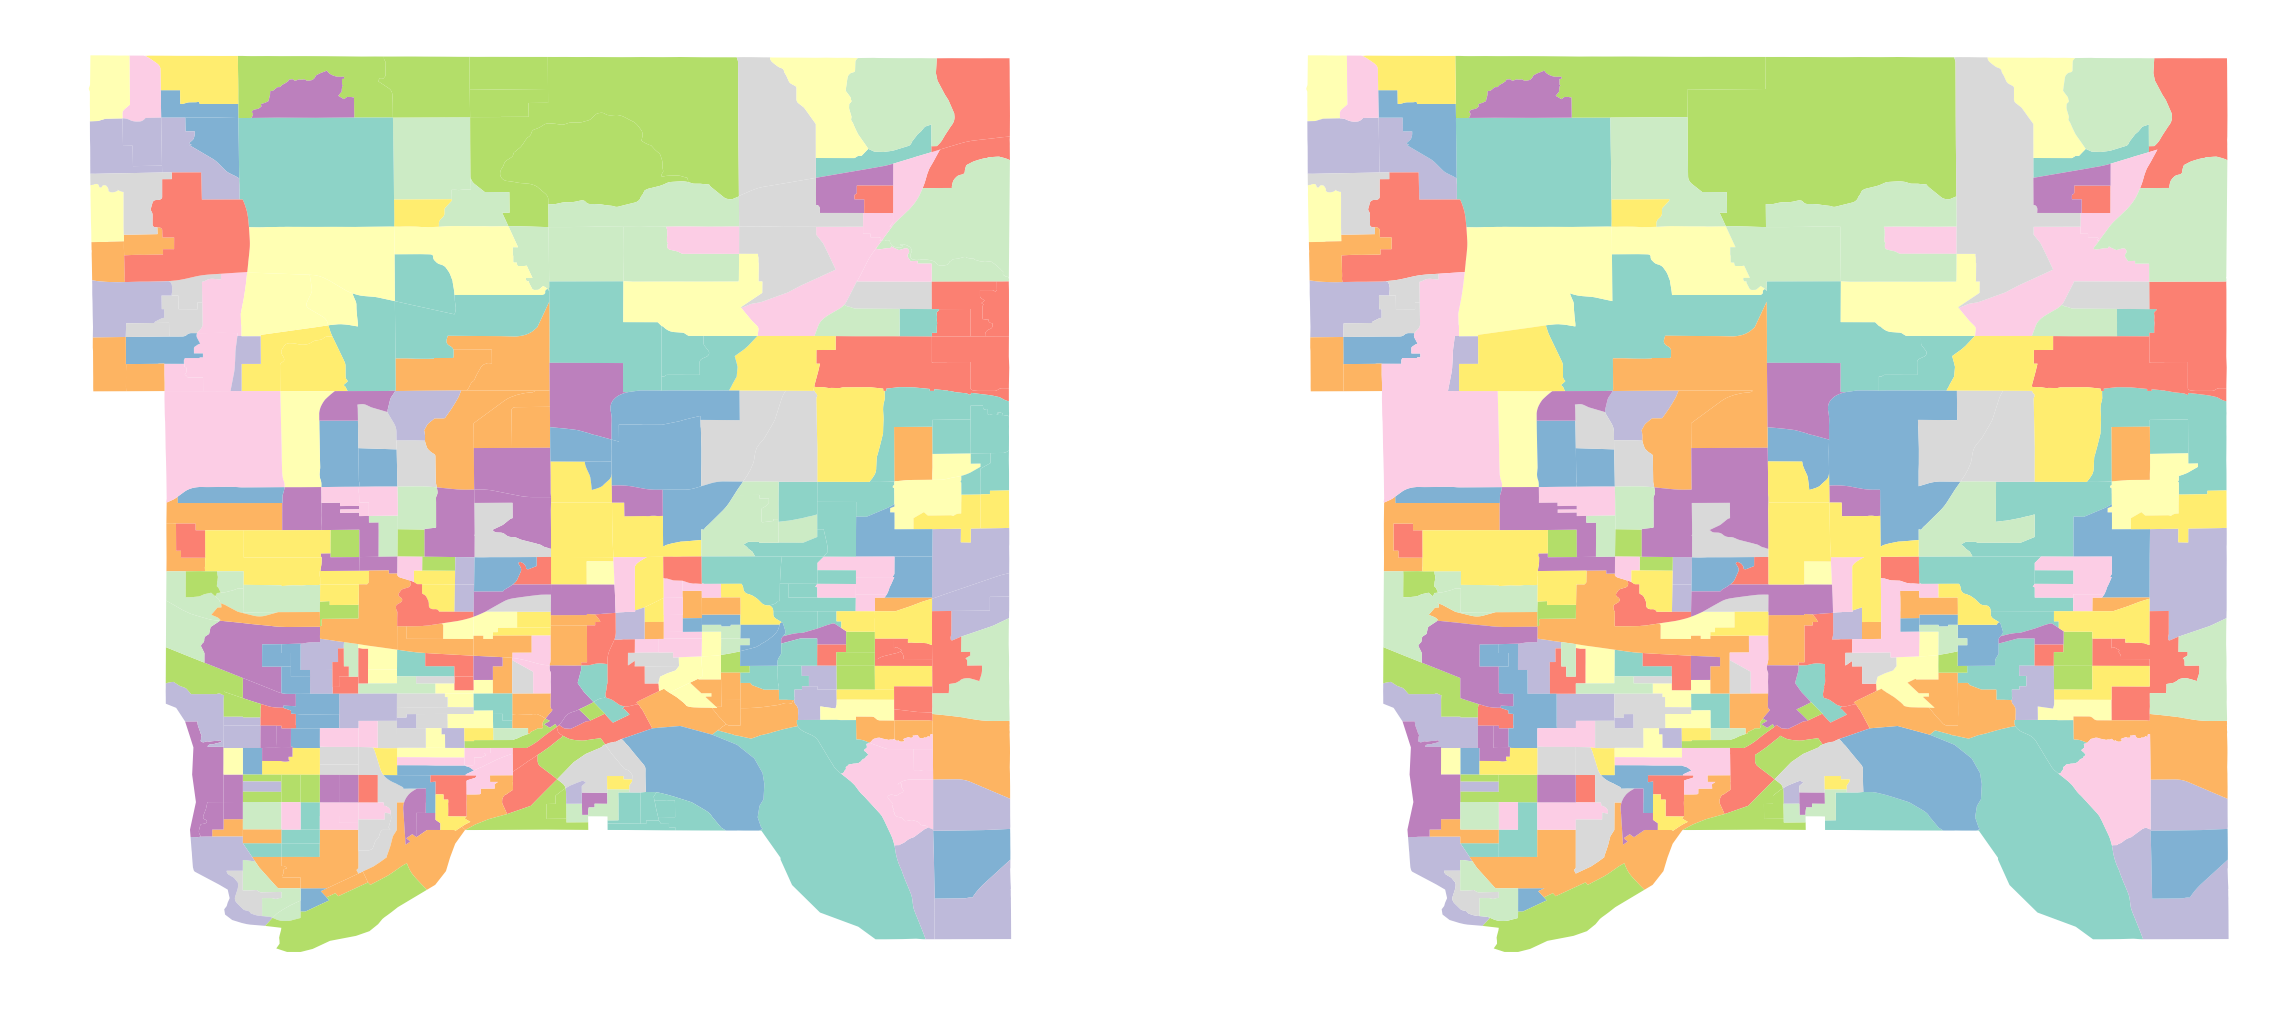

In [34]:
fig, axes = two_plot_setup()

# color tracts based on region ID
rids = copy.copy(results.region_ids)
shp_map['rids'] = rids
shp_map.plot('rids', categorical=True, alpha=1, colormap='Set3', axes=axes[0])

# disolve the tracts into regions
region_groups = shp_map.groupby('rids')
region_map = gp.GeoDataFrame(index=region_groups.indices.keys())
region_map['rids'] = region_groups.indices.keys()
region_map['geometry'] = region_groups.geometry.apply(shapely.ops.unary_union)
region_map.plot('rids', categorical=True,  colormap='Set3', axes=axes[1])

In [43]:
type(shp_map)

shp_map.to_file("output/prototype.shp")

geopandas.geodataframe.GeoDataFrame